## Importando bibliotecas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

## 01 Prevendo valores futuros

In [2]:

dados_f1 = pd.read_csv('../data/Temperatura_mensal_F1.csv')
dados_f1

,DATA,TEMP
0,1963-05-01,23.11
1,1963-06-01,24.20
2,1963-07-01,25.37
3,1963-08-01,23.86
4,1963-09-01,23.03
...,...,...
727,2023-12-01,19.49
728,2024-01-01,19.28
729,2024-02-01,19.73
730,2024-03-01,20.44


In [3]:
# verificar os tipos dos dados
dados_f1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATA    732 non-null    object 
 1   TEMP    732 non-null    float64
dtypes: float64(1), object(1)
memory usage: 11.6+ KB


In [4]:
# vamos converter para data 
dados_f1['DATA'] = pd.to_datetime(dados_f1['DATA'], format='%Y-%m-%d')
dados_f1.set_index(['DATA'], inplace=True, drop=True)
dados_f1

,TEMP
DATA,
1963-05-01,23.11
1963-06-01,24.20
1963-07-01,25.37
1963-08-01,23.86
1963-09-01,23.03
...,...
2023-12-01,19.49
2024-01-01,19.28
2024-02-01,19.73


<Axes: xlabel='DATA'>

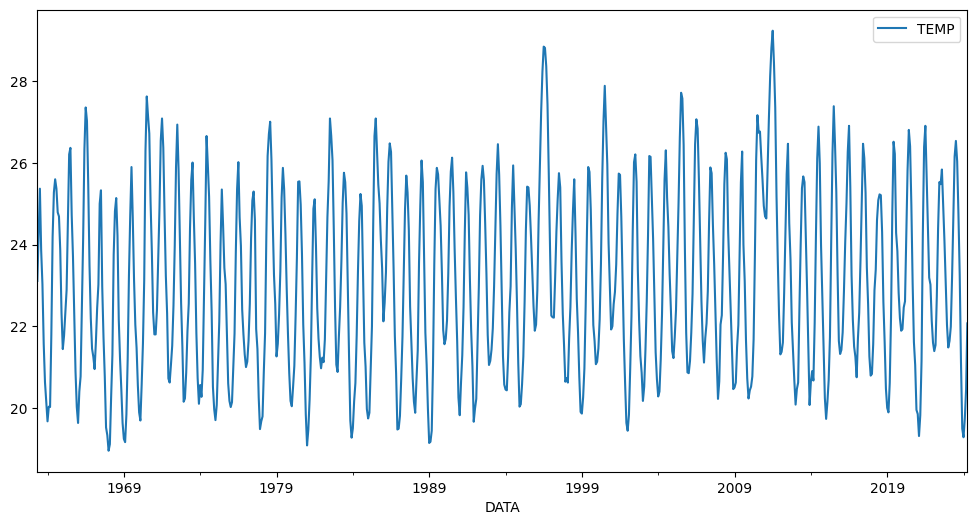

In [5]:
dados_f1.plot(figsize=(12,6))

In [6]:
# Utilizar o modelo naive, é um dos metodos de previsão mais simples, baseando-se na suposição de que o melhor
# preditor para qualquer ponto futuro é o valor mais recente disponivel na serie. Isso significa que a previsão para todos os ponto fututros será
# igual ao ultimo valor obseervado 

dados_f1.shift(1)

# como nosso objetivo é fazer uma previsao  com dados para 3 anos de oscilação de temperaruta Naives não é adequado pois no plot ele fica uma linha reta, para isso vamos de modelos matematicos

,TEMP
DATA,
1963-05-01,NaN
1963-06-01,23.11
1963-07-01,24.20
1963-08-01,25.37
1963-09-01,23.86
...,...
2023-12-01,21.11
2024-01-01,19.49
2024-02-01,19.28


In [7]:
# Avaliando a estacionariedade
from statsmodels.tsa.stattools import adfuller, kpss

def estac(dados):
    
    adf = adfuller(dados)
    print(f'Valor-p do teste ADF: {adf[1]:.4f}')
    if adf[1] > 0.05:
        print('Não rejeitar a Hipótese nula: a série não é estacionaria\n')
    else:
        print('rejeitar a Hipótese nula: a série é estacionaria\n')

    kpss_saida = kpss(dados)
    print(f'Valor-p do teste KPSS: {kpss_saida[1]:.4f}')
    if kpss_saida[1] > 0.05:
        print('Não rejeitar a Hipótese nula: a série é estacionaria\n')
    else:
        print('rejeitar a Hipótese nula: a série não é estacionaria\n')

In [8]:
estac(dados_f1)
# com a comprovação da serie ser estacionaria vamos aplicar um modelo AR

Valor-p do teste ADF: 0.0000
rejeitar a Hipótese nula: a série é estacionaria

Valor-p do teste KPSS: 0.0798
Não rejeitar a Hipótese nula: a série é estacionaria



In [9]:
# Divisão Treino/teste

divisao = int(len(dados_f1)*0.70)

treino = dados_f1.iloc[:divisao].asfreq('MS')
teste = dados_f1.iloc[divisao:].asfreq('MS')

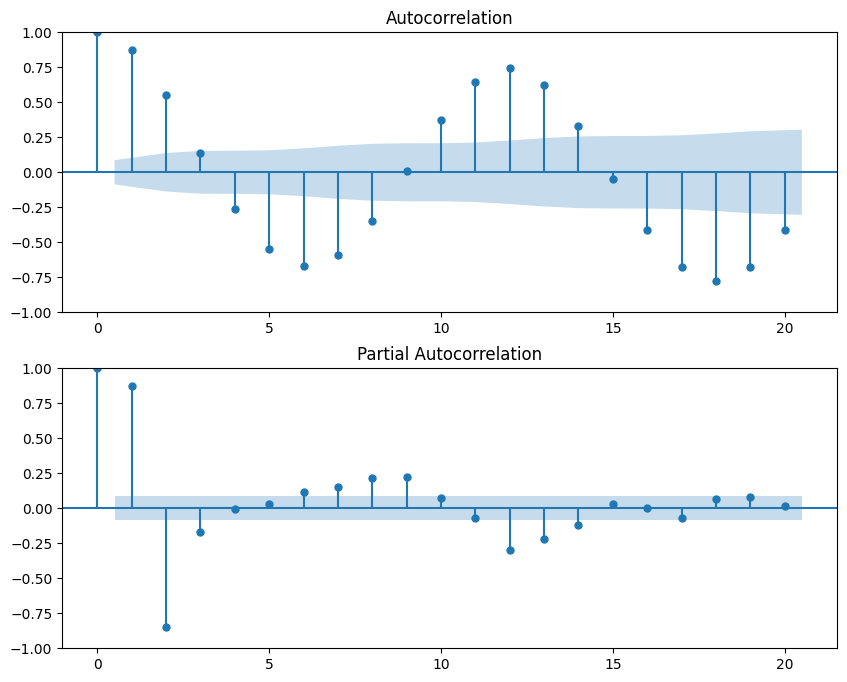

In [10]:
# Construir um modelo AR (Autoregressivo)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig = plt.figure(figsize=(10,8))

ax1 = fig.add_subplot(211)
fig = plot_acf(treino, lags=20, ax=ax1)

ax2 = fig.add_subplot(212)
fig = plot_pacf(treino, lags=20, ax=ax2)

In [12]:
from statsmodels.tsa.ar_model import AutoReg

ar_mod = AutoReg(treino, 14, old_names=False)
ar_res = ar_mod.fit()
print(ar_res.summary())

                            AutoReg Model Results                             
Dep. Variable:                   TEMP   No. Observations:                  512
Model:                    AutoReg(14)   Log Likelihood                -317.490
Method:               Conditional MLE   S.D. of innovations              0.458
Date:                Thu, 11 Dec 2025   AIC                            666.981
Time:                        06:27:33   BIC                            734.350
Sample:                    07-01-1964   HQIC                           693.421
                         - 12-01-2005                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0973      0.649      7.855      0.000       3.825       6.369
TEMP.L1        1.1971      0.044     27.078      0.000       1.110       1.284
TEMP.L2       -0.3092      0.069     -4.470      0.0

c:\Users\init\Documents\GitHub\Estudos-praticos\.venv\Lib\site-packages\statsmodels\tsa\ar_model.py:1138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ar_params[lag] = -params[i]


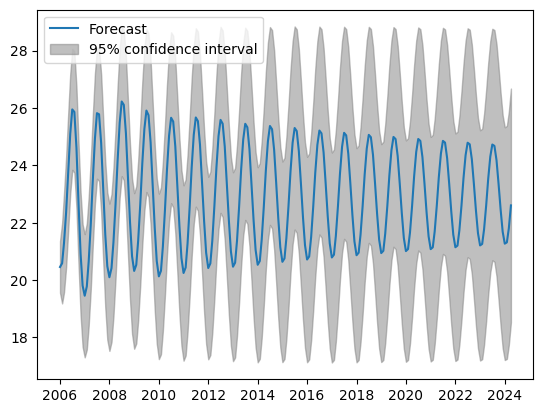

In [13]:
# previsao com autoreg
from statsmodels.tsa.ar_model import AutoRegResults

mod_result = AutoRegResults(ar_mod, ar_res.params, ar_res.cov_params())

fig = mod_result.plot_predict(len(treino), len(treino)+len(teste)-1)

In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def plot_prev(treino, teste, mod, nome_mod = ''):

  previsoes = mod.predict(len(treino), len(treino) + len(teste)-1, dynamic=False)

  plt.figure(figsize=(12, 5))

  plt.plot(teste.index, teste, label='Esperado')
  plt.plot(previsoes.index, previsoes, label='Previsto', color='red')

  plt.title(f'Previsão modelo {nome_mod}')
  plt.ylabel('Temperatura')
  plt.legend()
  plt.show()

  print('\nMétricas:\n')
  mae = mean_absolute_error(teste, previsoes)
  print(f'MAE: {mae}')

  mse = mean_squared_error(teste, previsoes)
  print(f'MSE: {mse}')

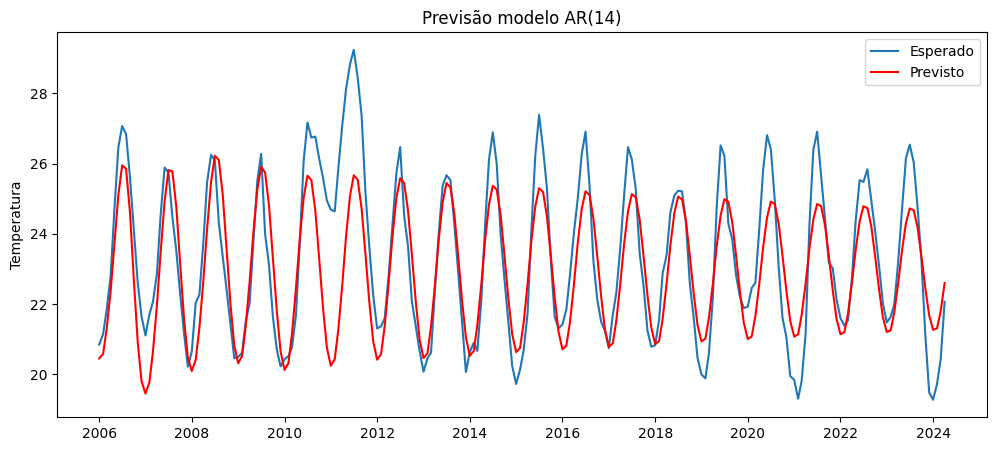


Métricas:

MAE: 1.0427063983973868
MSE: 1.8489038142171543


In [16]:
plot_prev(treino,teste, ar_res, 'AR(14)')

In [17]:
# Melhorando parametros

from statsmodels.tsa.ar_model import ar_select_order
ar_selecao = ar_select_order(treino, 35, old_names=False, ic='aic')

In [18]:
ar_selecao.ar_lags

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34]

In [ ]:
ar_sel_res = ar_selecao.model.fit()
print(ar_sel_res.summary())

# AIC menor que o ultimo modelo, aparentemente temos uma melhora na escolha de outro parametro

                            AutoReg Model Results                             
Dep. Variable:                   TEMP   No. Observations:                  512
Model:                    AutoReg(34)   Log Likelihood                -265.842
Method:               Conditional MLE   S.D. of innovations              0.422
Date:                Thu, 11 Dec 2025   AIC                            603.684
Time:                        06:49:53   BIC                            753.790
Sample:                    03-01-1966   HQIC                           662.698
                         - 12-01-2005                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4648      1.091      4.092      0.000       2.326       6.603
TEMP.L1        1.1355      0.045     25.067      0.000       1.047       1.224
TEMP.L2       -0.2017      0.068     -2.958      0.0